## Importação Dataset

In [76]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [77]:
database = pd.read_csv('database/airbnb.csv')

In [78]:
duplicated_rows = database.duplicated()
print(duplicated_rows.any())

False


In [79]:
database.columns

Index(['id', 'title', 'description', 'typeDescription', 'roomType',
       'discountedPrice', 'price', 'originalPrice', 'day5Price', 'url',
       'ratingValue', 'ratingReviewsCount', 'ratingGuestSatisfaction',
       'ratingCommunication', 'ratingCleanliness', 'ratingAccuracy',
       'ratingLocation', 'hostID', 'hostName', 'hostAbout', 'hostRating',
       'hostIsSuper', 'hostTimeResponse', 'hostResponseRate', 'latitude',
       'longitude', 'highlights', 'highlightsHost', 'highlightsLocation',
       'origin'],
      dtype='object')

In [80]:
# Remover "R$" e converter colunas de preço para float
def convert_price(value):
    """Remove o símbolo 'R$' e converte para float"""
    return float(value.replace("R$", "").replace(",", "").strip()) if isinstance(value, str) else value

In [81]:
database['discountedPrice'] = database['discountedPrice'].apply(convert_price)
database['price'] = database['price'].apply(convert_price)
database['originalPrice'] = database['originalPrice'].apply(convert_price)
database['day5Price'] = database['day5Price'].apply(convert_price)

In [82]:
database['originalPrice'] = database['originalPrice'].fillna(database['price'])

In [83]:
# Criar DataFrames filtrando pela coluna 'origin'
db_blm = database[database['origin'] == 'blm']
db_stm = database[database['origin'] == 'stm']

In [84]:
origin_room_type_counts = database.groupby(['origin', 'roomType']).size().unstack(fill_value=0)
print("Quantidade de tipos de hospedagem por origem:")
print(origin_room_type_counts)

Quantidade de tipos de hospedagem por origem:
roomType  Entire home/apt  Private room  Shared room
origin                                              
blm                   277           130            6
stm                   306           141            6


### Separação por Localização (Santarém e Alter do Chão)

In [85]:
from sklearn.cluster import KMeans
import folium
from folium.plugins import MarkerCluster, MiniMap

In [86]:
df_location_stm = db_stm[['id','latitude','longitude']].copy()

In [87]:
# retirar valores nulos
df_location_stm.dropna(axis=0,how='any',subset=['latitude','longitude'],inplace=True)

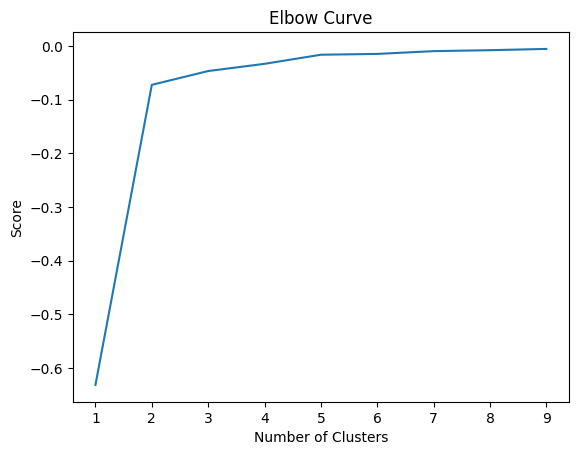

In [88]:
X=df_location_stm.loc[:,['id','latitude','longitude']]

# Elbow Curve
K_clusters = range(1,10)

kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = df_location_stm[['latitude']]
X_axis = df_location_stm[['longitude']]

score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [89]:
kmeans = KMeans(n_clusters = 2, init ='k-means++')
kmeans.fit(X[X.columns[1:3]]) # Compute k-means clustering.
X['cluster_label'] = kmeans.fit_predict(X[X.columns[1:3]])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(X[X.columns[1:3]]) # Labels of each point
X.head(10)

,id,latitude,longitude,cluster_label
413,1284848925482673940,-2.506643,-54.958631,1
414,1170406999244775557,-2.503780,-54.951200,1
415,1290829230739229679,-2.506362,-54.954638,1
416,763165324786463468,-2.510813,-54.955368,1
417,963094139487772842,-2.503500,-54.958700,1
418,925416981978176829,-2.501740,-54.948860,1
419,977645592663037493,-2.505468,-54.948459,1
420,708138361324411765,-2.505640,-54.957690,1
421,715183140964611968,-2.501770,-54.954950,1
422,40060640,-2.503850,-54.952210,1


In [90]:
loc_type_counts = X['cluster_label'].value_counts()
print("Quantidade por local:")
print(loc_type_counts)

Quantidade por local:
cluster_label
1    312
0    141
Name: count, dtype: int64


In [91]:
# Criar uma cópia do conjunto de dados db_stm
db_stm_copy = db_stm.copy()

# Mapear os valores de cluster_label para 'alter' e 'stm'
cluster_label_map = {1: 'alter', 0: 'stm'}
X['cluster_label_mapped'] = X['cluster_label'].map(cluster_label_map)

# Mesclar db_stm_copy com X para adicionar a nova coluna
db_stm_copy = db_stm_copy.merge(X[['id', 'cluster_label_mapped']], on='id', how='left')

# Renomear a nova coluna para 'location'
db_stm_copy.rename(columns={'cluster_label_mapped': 'location'}, inplace=True)

# Exibir as primeiras linhas do novo DataFrame
db_stm_copy.head()

,id,title,description,typeDescription,roomType,discountedPrice,price,originalPrice,day5Price,url,...,hostIsSuper,hostTimeResponse,hostResponseRate,latitude,longitude,highlights,highlightsHost,highlightsLocation,origin,location
0,1284848925482673940,Flat Paraíso da praia 20324,Relaxe neste espaço calmo e cheio de estilo. A...,"Espaço inteiro: apartamento em Santarém, Brasil",Entire home/apt,NaN,NaN,NaN,1.25,https://www.airbnb.com/rooms/12848489254826739...,...,True,Responde em poucas horas,Taxa de resposta: 100%,-2.506643,-54.958631,"['Comodidades ao ar livre', 'Self check-in', '...","['Meu trabalho: Administradora', 'Moro em: San...","[nan, nan]",stm,alter
1,1170406999244775557,Quarto Muiraquitã •\nCasa AmazôniKaa,Este lugar especial é muito bem localizado pró...,"Quarto em Santarém, Brasil",Private room,235.0,267.0,267.0,1.00,https://www.airbnb.com/rooms/11704069992447755...,...,True,Responde em até 1 hora,Taxa de resposta: 100%,-2.503780,-54.951200,"['Quarto em casa', 'Caminhada de 4 minutos até...","['Meu trabalho: Guia de Turismo', 'Passo muito...","[nan, nan]",stm,alter
2,1290829230739229679,Quarto Triplo 2-Pousada Orquídea,"Localizada no centro de Alter do Chão, a 500 ...","Quarto em Santarém, Brasil",Private room,NaN,NaN,NaN,800.00,https://www.airbnb.com/rooms/12908292307392296...,...,False,Responde em até 1 hora,Taxa de resposta: 100%,-2.506362,-54.954638,"['Quarto em pousada', 'Comodidades ao ar livre...","['Onde estudei: UFMT', 'Meu trabalho: Engenhei...","[nan, nan]",stm,alter
3,763165324786463468,Pousada cardume,Tudo o que você quer explorar está a um passo ...,"Quarto em Santarém, Brasil",Private room,NaN,NaN,NaN,650.00,https://www.airbnb.com/rooms/76316532478646346...,...,True,Responde em até 1 hora,Taxa de resposta: 100%,-2.510813,-54.955368,"['Ótima experiência de check-in', 'Quarto em p...","['Nasci na década de 80', 'Onde estudei: unino...","[nan, nan]",stm,alter
4,963094139487772842,Quarto Tarubá,Em Alter do chão 🏡850 metros da Ilha do Amor e...,"Quarto em Santarém, Brasil",Private room,NaN,NaN,NaN,285.00,https://www.airbnb.com/rooms/96309413948777284...,...,True,Responde em até 1 hora,Taxa de resposta: 99%,-2.503500,-54.958700,"['Quarto em casa', 'Self check-in', 'Cancelame...","['Meu trabalho: airbnb', 'Idiomas: português',...","[nan, nan]",stm,alter


In [92]:
db_only_stm = db_stm_copy[db_stm_copy['location'] == 'stm']
db_only_alter = db_stm_copy[db_stm_copy['location'] == 'alter']

In [93]:
db_only_alter.shape

(312, 31)

In [94]:
db_only_stm.shape

(141, 31)

## Mapa : Quantitativo por Bairro

In [95]:
# Create a map centered around the mean latitude and longitude
map_center_stmalter = [X['latitude'].mean(), X['longitude'].mean()]
map_clusters_stmalter = folium.Map(location=map_center_stmalter, zoom_start=12, tiles='cartodb positron')

# Add points to the map
for idx, row in X.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        color='green' if row['cluster_label'] == 0 else 'red',
        fill=True,
        fill_color='green' if row['cluster_label'] == 0 else 'red',
        fill_opacity=0.6
    ).add_to(map_clusters_stmalter)

#Add cluster centers to the map
"""
for center in centers:
    folium.Marker(
        location=[center[0], center[1]],
        icon=folium.Icon(color='black')
    ).add_to(map_clusters_stmalter)
"""

# Display the map
map_clusters_stmalter

In [96]:
import json

map_center_lat_stm= db_only_stm['latitude'].mean()
map_center_lon_stm= db_only_stm['longitude'].mean()

map_stm = folium.Map((map_center_lat_stm, map_center_lon_stm), tiles="cartodb positron", control_scale=True,)

geojson_path = "geojson/bairros.geojson"

with open(geojson_path, encoding='utf-8') as f:
    geojson_data = json.load(f)

#Nome dos bairros
folium.GeoJson(
    geojson_data,
    tooltip=folium.GeoJsonTooltip(fields=['name'], aliases=['Bairro:'])
).add_to(map_stm)


#Pontos de hospedagem
marker_cluster_map_stm = MarkerCluster().add_to(map_stm)

# iterrows() -> (indíce, linha)
for i, row in db_only_stm.iterrows():
    try: 
        lat = row['latitude']
        lon = row['longitude']

        # varificação se os valores em lat e lon são números e se são int ou float, caso seja avaliado como invalido irá pular (continue) a coordenada da linha
        if pd.isna(lat) or pd.isna(lon) or not (isinstance(lat, (int,float)) and isinstance(lon, (int, float))): 
            continue

        folium.Marker(
            location=[lat, lon],
            icon=folium.Icon(color='gray')
        ).add_to(marker_cluster_map_stm)

    except (KeyError, TypeError) as e:
        print(f"Erro processando linha de index {i}:{e}")
        continue

map_stm

In [97]:
import geopandas as gpd
from shapely.geometry import Point

# Carregar os dados geojson dos bairros
bairros_gdf = gpd.read_file(geojson_path)

# Definir o CRS do GeoDataFrame dos bairros
bairros_gdf.crs = "EPSG:4674"

# Criar um GeoDataFrame para as hospedagens
geometry = [Point(xy) for xy in zip(db_only_stm['longitude'], db_only_stm['latitude'])]
hospedagens_gdf = gpd.GeoDataFrame(db_only_stm, geometry=geometry, crs="EPSG:4674")

# Realizar a interseção espacial para encontrar o bairro de cada hospedagem
hospedagens_bairros = gpd.sjoin(hospedagens_gdf, bairros_gdf, how="left", predicate='within')

# Contar o número de hospedagens por bairro
quantitativo_hospedagens_bairro = hospedagens_bairros.groupby('name').size().reset_index(name='quantidade')

quantitativo_hospedagens_bairro = quantitativo_hospedagens_bairro.sort_values(by='quantidade', ascending=False)
print(quantitativo_hospedagens_bairro)

                    name  quantidade
22           Santa Clara          12
0        Aeroporto Velho          11
5                 Centro          11
19          Nova Vitória          10
4              Caranazal           8
16              Maracaña           8
9                 Fátima           8
1                 Aldeia           7
20               Prainha           6
10         Interventória           6
14             Liberdade           6
6             Diamantino           5
13              Laguinho           4
11       Jardim Santarém           4
3              Aparecida           4
8               Floresta           3
15                Mapiri           2
2               Alvorada           2
12                 Jutaí           1
17            Maracaña I           1
18                Mararu           1
7              Esperança           1
21  Residencial Salvação           1
23            Santissimo           1
24           Santo André           1
25         São Cristóvão           1
2

In [98]:
import geopandas as gpd
import folium

# Carregar os dados geojson dos bairros
bairros_gdf = gpd.read_file(geojson_path)
bairros_gdf.crs = "EPSG:4674"

# Mesclar os dados de bairros com o quantitativo de hospedagens
bairros_com_quantitativo = bairros_gdf.merge(quantitativo_hospedagens_bairro, left_on='name', right_on='name', how='left')

# Preencher valores nulos com 0 (bairros sem hospedagens)
bairros_com_quantitativo['quantidade'] = bairros_com_quantitativo['quantidade'].fillna(0).astype(int)

# Projetar as geometrias para UTM 21S (EPSG:31981)
bairros_com_quantitativo_projetado = bairros_com_quantitativo.to_crs("EPSG:31981")

# Calcular o centróide com as geometrias projetadas
centroide = bairros_com_quantitativo_projetado.geometry.centroid

# Criar o mapa centralizado no centróide
map_stm_bairros = folium.Map((map_center_lat_stm, map_center_lon_stm), tiles="cartodb positron", control_scale=True, zoom_start=13)

# Adicionar as geometrias dos bairros
folium.GeoJson(
    bairros_com_quantitativo,
    name='Bairros'
).add_to(map_stm_bairros)

# Adicionar a camada choropleth
folium.Choropleth(
    geo_data=bairros_com_quantitativo,
    name='Choropleth',
    data=bairros_com_quantitativo,
    columns=['name', 'quantidade'],
    key_on='feature.properties.name',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Número de Hospedagens',
).add_to(map_stm_bairros)

# Adicionar controle de camadas
folium.LayerControl().add_to(map_stm_bairros)

# Salvar o mapa em um arquivo HTML
#map_stm_bairros.save('mapa_hospedagens_bairros.html')

map_stm_bairros


## Correlação entre Avaliação e Preço

In [103]:
database.head(5)

,id,title,description,typeDescription,roomType,discountedPrice,price,originalPrice,day5Price,url,...,hostRating,hostIsSuper,hostTimeResponse,hostResponseRate,latitude,longitude,highlights,highlightsHost,highlightsLocation,origin
0,23562655,Sofisticado Loft Mobiliado no Coração do Umarizal,"Sofisticado Loft de 52 m2, no coração do Bairr...","Espaço inteiro: loft em Belém, Brasil",Entire home/apt,NaN,423.0,423.0,1.71,https://www.airbnb.com/rooms/23562655?locale=p...,...,4.90,True,Responde em até 1 hora,Taxa de resposta: 100%,-1.445973,-48.484032,"['Aproveite para dar um mergulho', 'Academia e...","['Idiomas: inglês, francês, português e espanh...",['O bairro do Umarizal é o mais nobre da cidad...,blm
1,912967533767582954,"bela vista, ótima localização, conforto","AP 1/4 moderno, aconchegante, em local seguro ...","Espaço inteiro: apartamento em Belém, Brasil",Entire home/apt,NaN,518.0,518.0,2.06,https://www.airbnb.com/rooms/91296753376758295...,...,4.96,True,Responde em até 1 hora,Taxa de resposta: 100%,-1.441200,-48.491050,"['No top 10% das acomodações', 'Comodidades ao...","['Moro em: Belém, Brasil', nan, nan, nan, nan]","['bairro nobre, próximo a shopping, supermer...",blm
2,1253877901508012768,Quarto e cozinha bem localizado acesso individ...,Local privilegiado com entrada independente. O...,"Espaço inteiro: casa em Belém, Brasil",Entire home/apt,NaN,135.0,135.0,575.00,https://www.airbnb.com/rooms/12538779015080127...,...,4.90,True,Responde em até 1 hora,Taxa de resposta: 100%,-1.443930,-48.485570,"['Experiência de check-in excepcional', 'Ótimo...","[nan, nan, nan, nan, nan]","[nan, nan]",blm
3,1005937618095866893,Quarto com vista para o rio,"O apartamento é simples, mas arejado e ilumina...","Quarto em Belém, Brasil",Private room,NaN,135.0,135.0,530.00,https://www.airbnb.com/rooms/10059376180958668...,...,4.93,True,Responde em poucas horas,Taxa de resposta: 100%,-1.455178,-48.496070,"['No top 5% das acomodações', 'Quarto em apart...","['Nasci na década de 90', 'Meu trabalho: Bancá...","[nan, nan]",blm
4,1310394345938397835,Suíte somente para você no bairro Marambaia.,Uma suíte somente para você no bairro Marambai...,"Microcasa em Belém, Brasil",Entire home/apt,69.0,69.0,78.0,330.00,https://www.airbnb.com/rooms/13103943459383978...,...,4.91,False,Responde em até 1 hora,Taxa de resposta: 100%,-1.413707,-48.439612,"['No top 10% das acomodações', 'Experiência de...","['Meu trabalho: Pereirão/Faz tudo', 'Curiosida...","[nan, nan]",blm


In [100]:
correlation_price = database[['discountedPrice', 'originalPrice', 'ratingValue']].corr()

print("Correlação entre Preço e Avaliações:")
print(correlation_price)

Correlação entre Preço e Avaliações:
                 discountedPrice  originalPrice  ratingValue
discountedPrice         1.000000       0.679777    -0.109781
originalPrice           0.679777       1.000000    -0.094315
ratingValue            -0.109781      -0.094315     1.000000


In [110]:
db_only_alter.info()

<class 'pandas.core.frame.DataFrame'>
Index: 312 entries, 0 to 451
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       312 non-null    int64  
 1   title                    312 non-null    object 
 2   description              311 non-null    object 
 3   typeDescription          312 non-null    object 
 4   roomType                 312 non-null    object 
 5   discountedPrice          76 non-null     float64
 6   price                    76 non-null     float64
 7   originalPrice            76 non-null     float64
 8   day5Price                312 non-null    float64
 9   url                      312 non-null    object 
 10  ratingValue              244 non-null    float64
 11  ratingReviewsCount       244 non-null    float64
 12  ratingGuestSatisfaction  244 non-null    float64
 13  ratingCommunication      244 non-null    float64
 14  ratingCleanliness        244 no

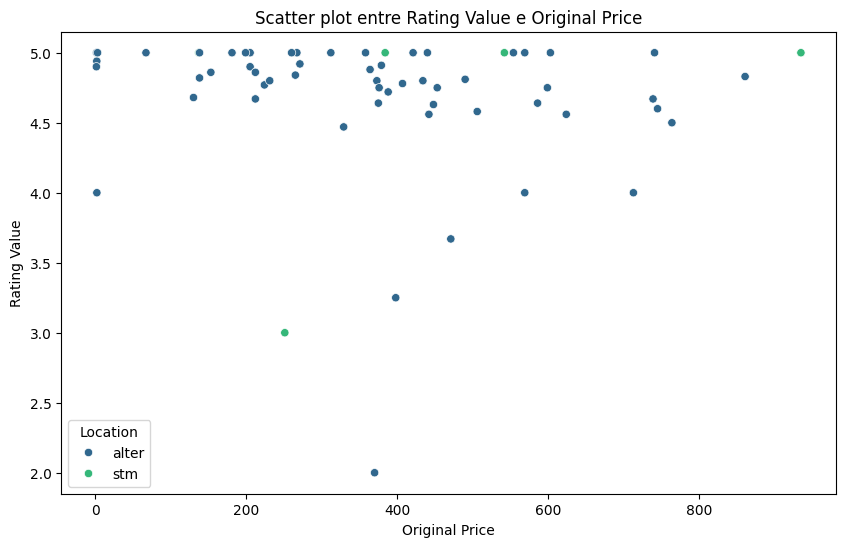

In [111]:
# Scatter plot entre ratingValue e originalPrice levando em consideração a coluna location
plt.figure(figsize=(10, 6))
sns.scatterplot(data=db_stm_copy, x='originalPrice', y='ratingValue', hue='location', palette='viridis')
plt.title('Scatter plot entre Rating Value e Original Price')
plt.xlabel('Original Price')
plt.ylabel('Rating Value')
plt.legend(title='Location')
plt.show()

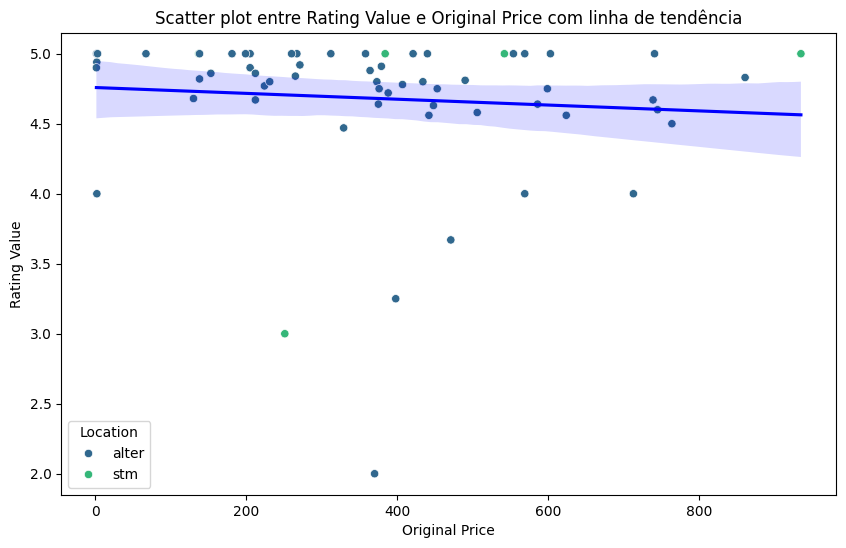

In [113]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=db_stm_copy, x='originalPrice', y='ratingValue', hue='location', palette='viridis')
sns.regplot(data=db_stm_copy, x='originalPrice', y='ratingValue', scatter=False, color='blue')
plt.title('Scatter plot entre Rating Value e Original Price com linha de tendência')
plt.xlabel('Original Price')
plt.ylabel('Rating Value')
plt.legend(title='Location')
plt.show()

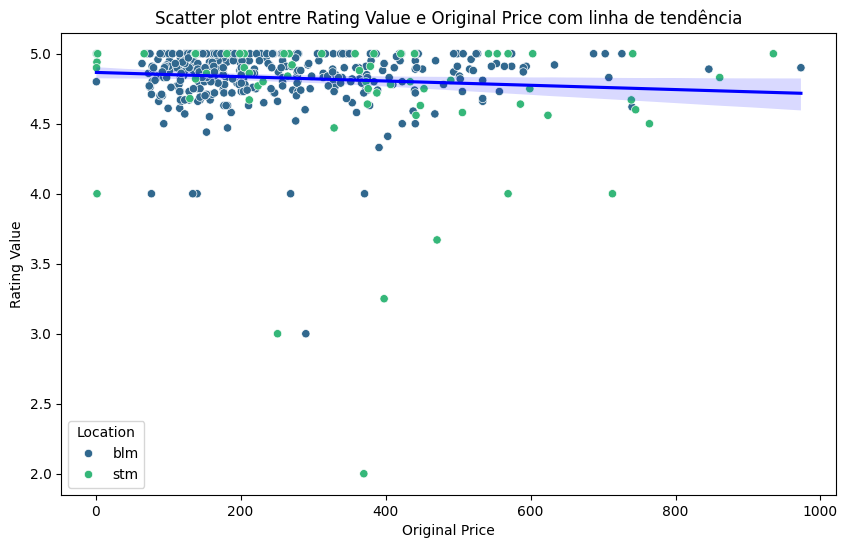

In [115]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=database, x='originalPrice', y='ratingValue', hue='origin', palette='viridis')
sns.regplot(data=database, x='originalPrice', y='ratingValue', scatter=False, color='blue')
plt.title('Scatter plot entre Rating Value e Original Price com linha de tendência')
plt.xlabel('Original Price')
plt.ylabel('Rating Value')
plt.legend(title='Location')
plt.show()

hostIsSuper    False  True 
priceCategory              
0-200            129    110
200-400           72     98
400-600           41     33
600-800           11      5
800-1000           4      2
1000-2000          0      0


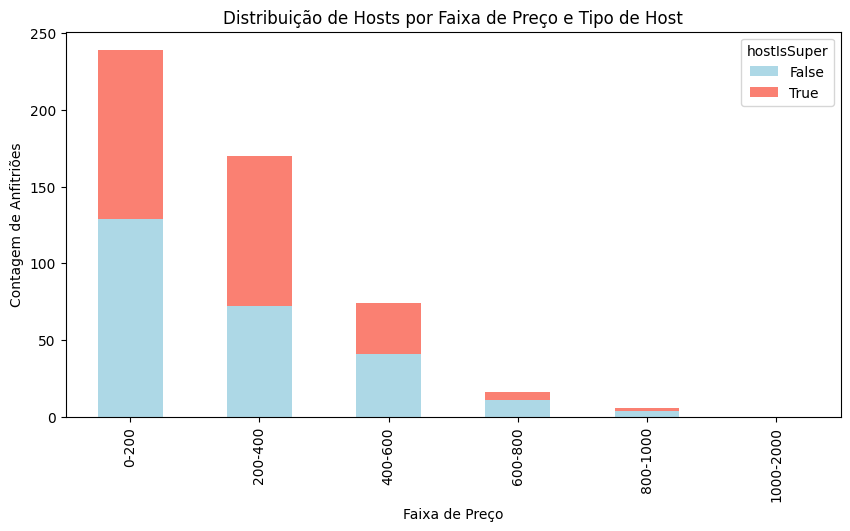

In [117]:
# Classificando as faixas de preço
database['priceCategory'] = pd.cut(database['originalPrice'], bins=[0, 200, 400, 600, 800, 1000, 2000], labels=['0-200', '200-400', '400-600', '600-800', '800-1000', '1000-2000'])

# Gráfico de Barras Empilhadas
price_stack = database.groupby(['priceCategory', 'hostIsSuper'], observed=False).size().unstack().fillna(0)
print(price_stack)  # Mostrar os quantitativos

price_stack.plot(kind='bar', stacked=True, figsize=(10, 5), color=['lightblue', 'salmon'])
plt.xlabel('Faixa de Preço')
plt.ylabel('Contagem de Anfitriões')
plt.title('Distribuição de Hosts por Faixa de Preço e Tipo de Host')
plt.show()

In [124]:
price_origin_stack = database.groupby(['priceCategory', 'origin'], observed=True).size().unstack().fillna(0)
print(price_origin_stack)

origin         blm  stm
priceCategory          
0-200          212   27
200-400        138   32
400-600         54   20
600-800          7    9
800-1000         2    4


### Avaliações Específicas

In [127]:
import statsmodels.api as sm

# Selecionar as colunas de características e a coluna alvo
X = db_stm_copy[['ratingReviewsCount', 'ratingGuestSatisfaction', 'ratingCommunication', 'ratingCleanliness', 'ratingAccuracy', 'ratingLocation', 'hostRating']].dropna()
y = db_stm_copy.loc[X.index, 'ratingValue']

# Adicionar uma constante para o intercepto
X = sm.add_constant(X)

# Ajustar o modelo de regressão linear múltipla
model = sm.OLS(y, X).fit()

# Exibir o resumo do modelo
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            ratingValue   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     156.8
Date:                Sun, 23 Feb 2025   Prob (F-statistic):          4.12e-102
Time:                        14:06:11   Log-Likelihood:                 94.519
No. Observations:                 346   AIC:                            -173.0
Df Residuals:                     338   BIC:                            -142.3
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

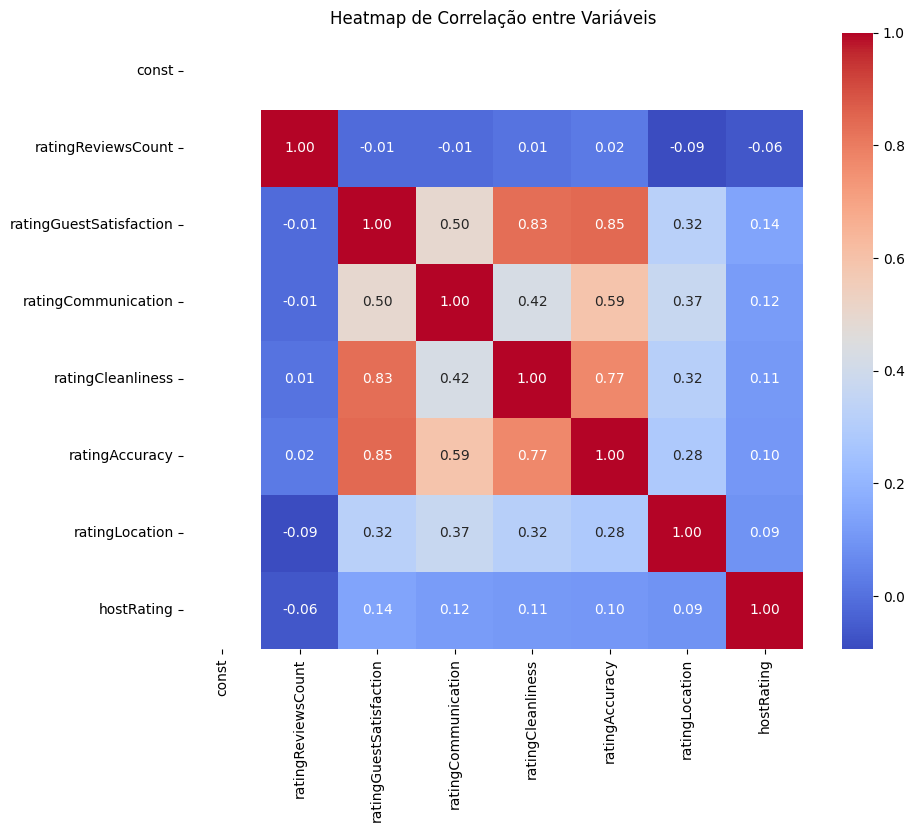

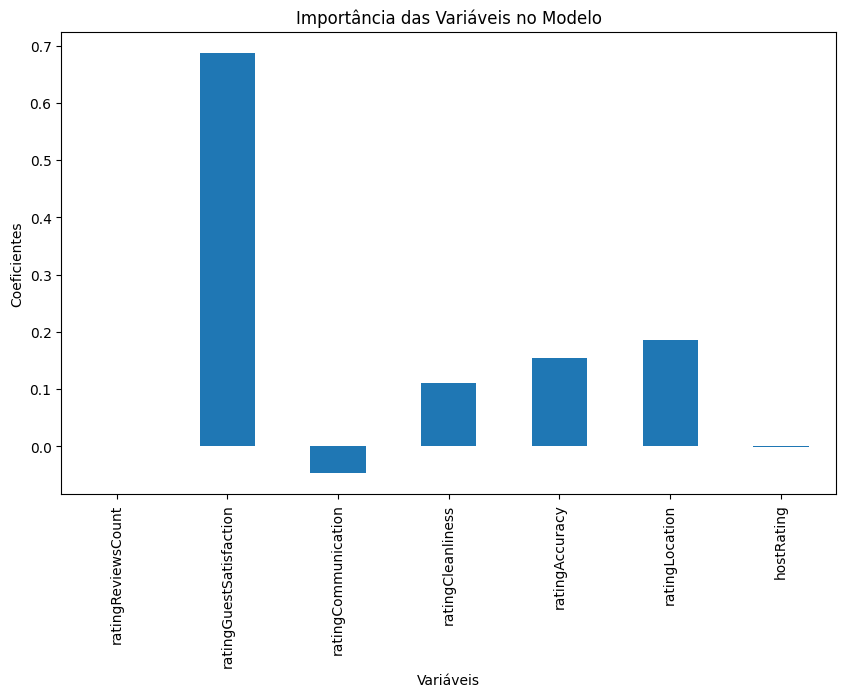

In [128]:
# 1. Correlação entre as variáveis (heatmap)
correlation_matrix = X.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap de Correlação entre Variáveis')
plt.show()

# 2. Importância das variáveis no modelo (gráfico de barras)
coefficients = model.params[1:]  # Excluindo a constante
plt.figure(figsize=(10, 6))
coefficients.plot(kind='bar')
plt.title('Importância das Variáveis no Modelo')
plt.xlabel('Variáveis')
plt.ylabel('Coeficientes')
plt.show()

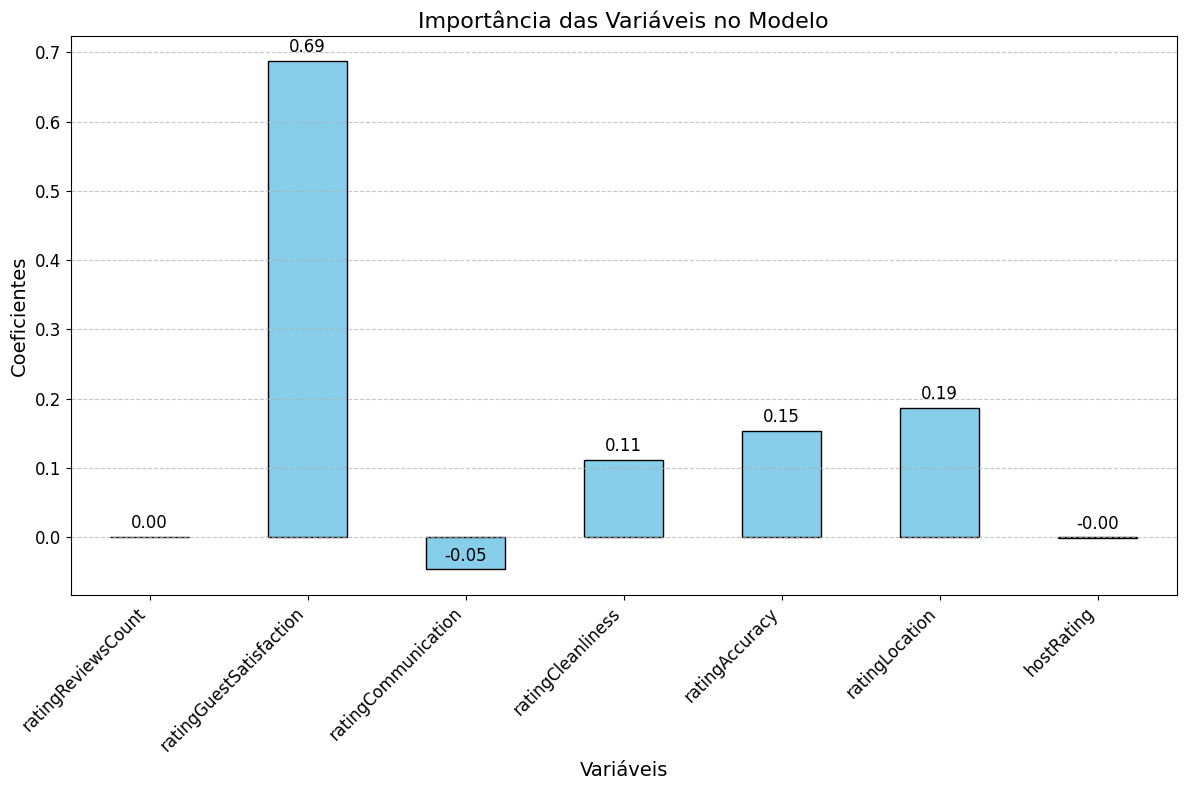

In [129]:
coefficients = model.params[1:]  # Excluindo a constante
plt.figure(figsize=(12, 8))
ax = coefficients.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Importância das Variáveis no Modelo', fontsize=16)
plt.xlabel('Variáveis', fontsize=14)
plt.ylabel('Coeficientes', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# Adicionar valores aos rótulos das barras
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

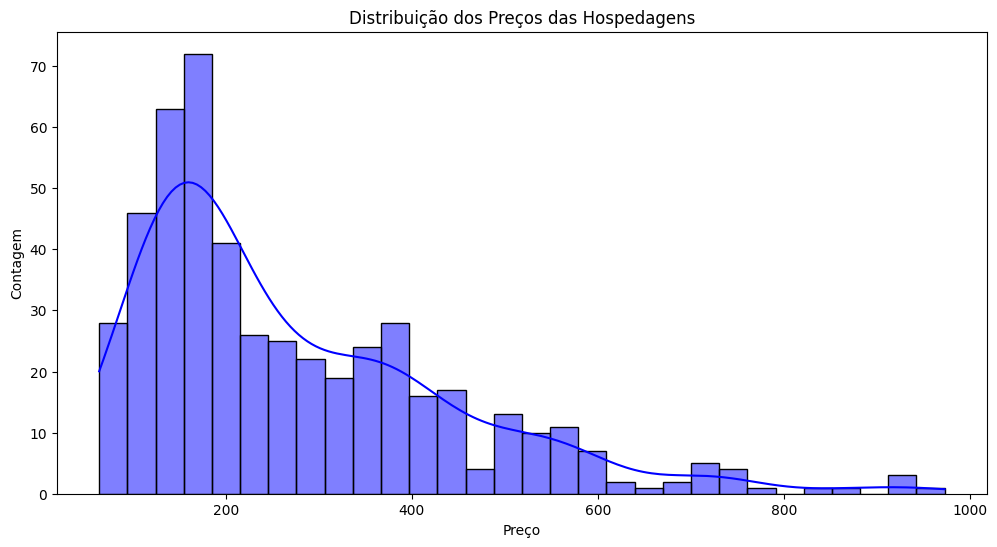

In [137]:
# Filtrar os preços válidos (não nulos, não zero e não vazios)
valid_prices = database['originalPrice'].dropna()
valid_prices = valid_prices[valid_prices > 5]

# Distribuição dos Preços das Hospedagens
plt.figure(figsize=(12, 6))
sns.histplot(valid_prices, bins=30, kde=True, color='blue')
plt.xlabel('Preço')
plt.ylabel('Contagem')
plt.title('Distribuição dos Preços das Hospedagens')
plt.show()

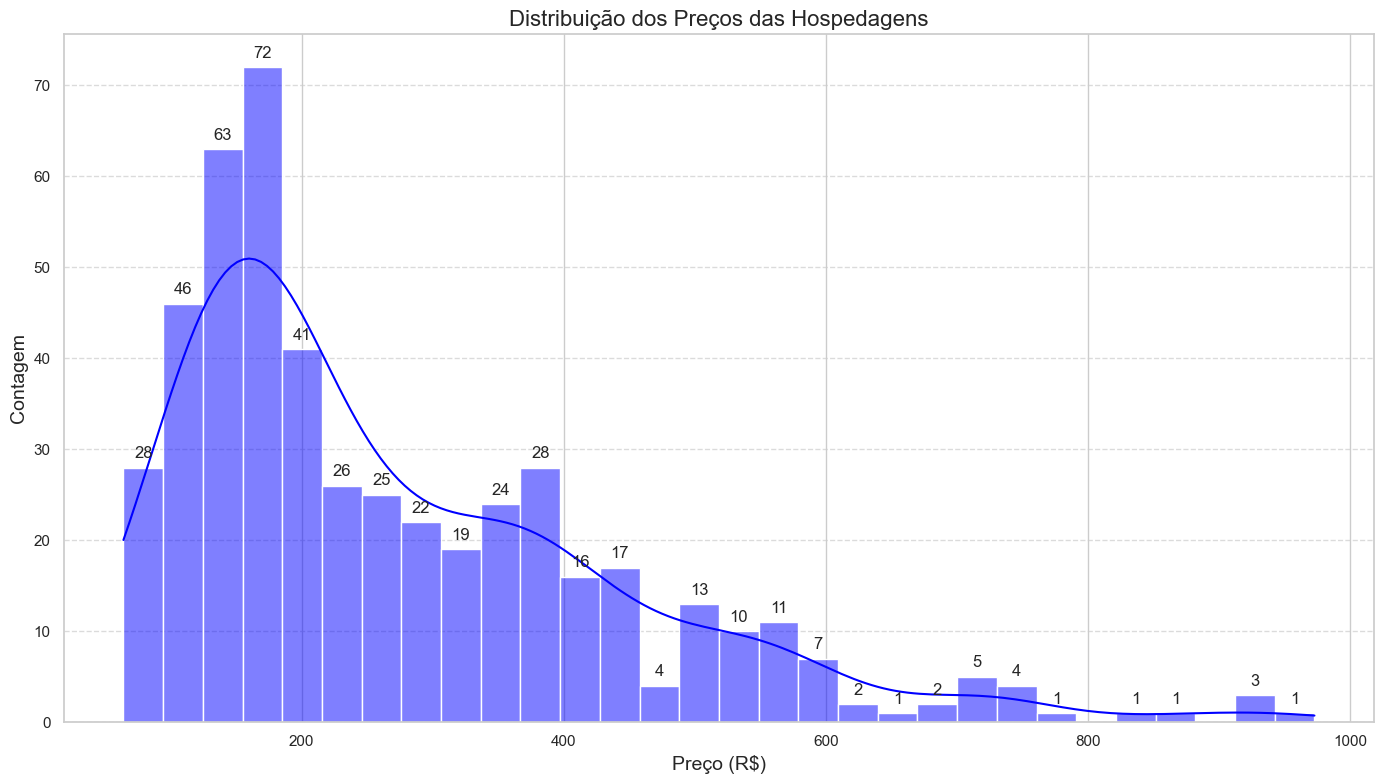

In [138]:
# Filtrar os preços válidos (não nulos, não zero e não vazios)
valid_prices = database['originalPrice'].dropna()
valid_prices = valid_prices[valid_prices > 5]

# Distribuição dos Preços das Hospedagens
plt.figure(figsize=(14, 8))
sns.set_theme(style="whitegrid")

# Criar o histograma com KDE
ax = sns.histplot(valid_prices, bins=30, kde=True, color='blue')

# Adicionar rótulos e título
plt.xlabel('Preço (R$)', fontsize=14)
plt.ylabel('Contagem', fontsize=14)
plt.title('Distribuição dos Preços das Hospedagens', fontsize=16)

# Adicionar rótulos de valores nas barras
for p in ax.patches:
    height = p.get_height()
    if height > 0:  # Adicionar rótulo apenas se a altura for maior que zero
        ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=12)

# Melhorar a visualização da grade
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar o gráfico
plt.tight_layout()
plt.show()

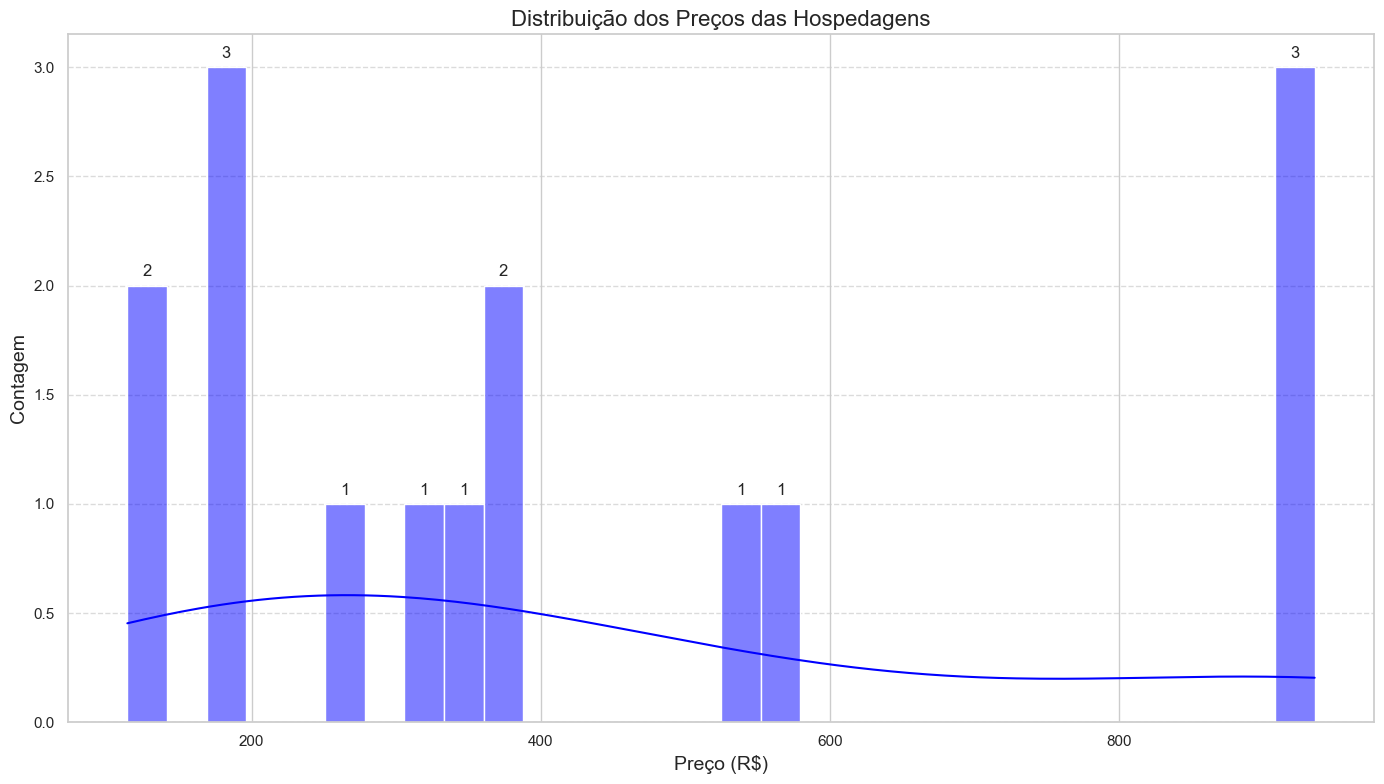

In [139]:
# Filtrar os preços válidos (não nulos, não zero e não vazios)
valid_prices = db_only_stm['originalPrice'].dropna()
valid_prices = valid_prices[valid_prices > 5]

# Distribuição dos Preços das Hospedagens
plt.figure(figsize=(14, 8))
sns.set_theme(style="whitegrid")

# Criar o histograma com KDE
ax = sns.histplot(valid_prices, bins=30, kde=True, color='blue')

# Adicionar rótulos e título
plt.xlabel('Preço (R$)', fontsize=14)
plt.ylabel('Contagem', fontsize=14)
plt.title('Distribuição dos Preços das Hospedagens', fontsize=16)

# Adicionar rótulos de valores nas barras
for p in ax.patches:
    height = p.get_height()
    if height > 0:  # Adicionar rótulo apenas se a altura for maior que zero
        ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=12)

# Melhorar a visualização da grade
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar o gráfico
plt.tight_layout()
plt.show()

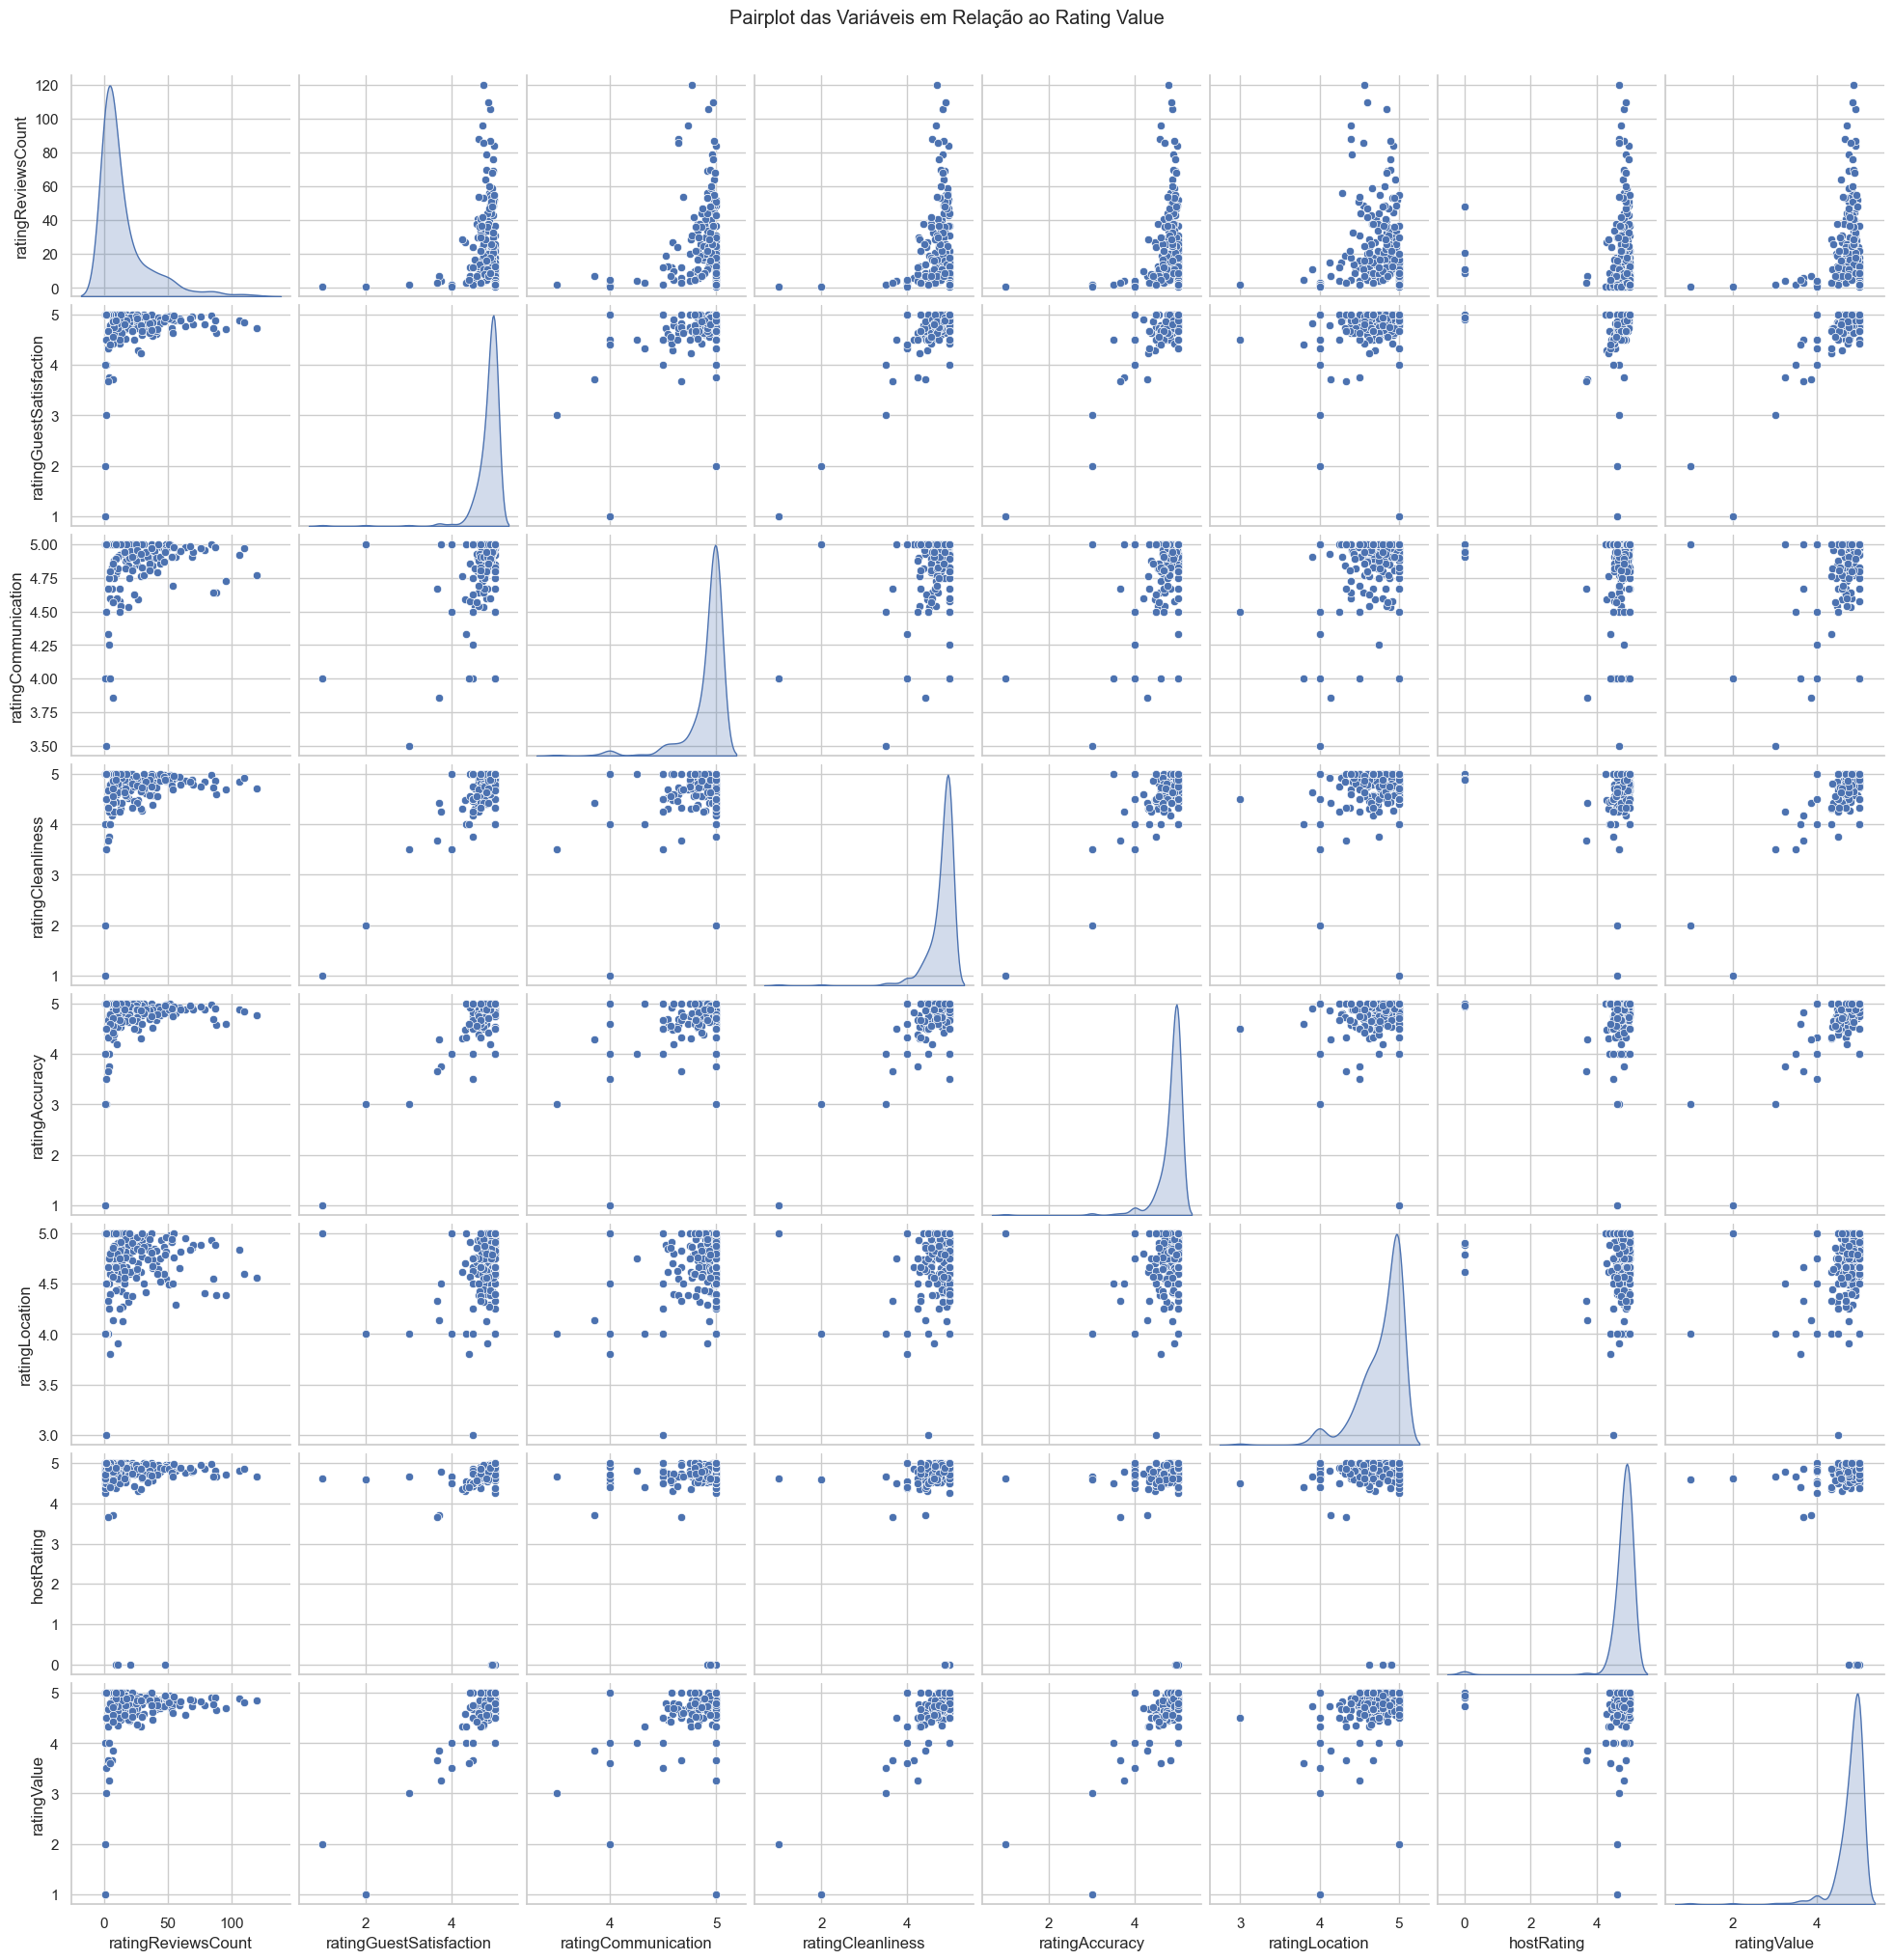

In [140]:
# Selecionar as colunas de interesse
columns_of_interest = ['ratingReviewsCount', 'ratingGuestSatisfaction', 'ratingCommunication', 'ratingCleanliness', 'ratingAccuracy', 'ratingLocation', 'hostRating', 'ratingValue']

# Filtrar o DataFrame para as colunas de interesse
df_pairplot = db_stm_copy[columns_of_interest].dropna()

# Criar o pairplot
sns.pairplot(df_pairplot, kind='scatter', diag_kind='kde')
plt.suptitle('Pairplot das Variáveis em Relação ao Rating Value', y=1.02)
plt.show()